In [1]:
#https://github.com/maybe-hello-world/MountainCarSolvers
%tensorflow_version 1.x
import gym
import tensorflow as tf
import numpy as np
import logging
from typing import Union

from tqdm import tqdm
from collections import defaultdict

reward_shaper = defaultdict(lambda: lambda obs, next_obs, rew: rew)  # default reward shaping is no shaping
reward_shaper.update({
    # reward shaping for MountainCar-v0: maximize speed
    "MountainCarContinuous-v0":
        lambda obs, next_obs, rew:
        abs(1 + next_obs[0] - obs[0]) ** 5
        + (10 + obs[0] * 30 if obs[0] > 0.3 else rew)
        + (obs[0] * 10000 if obs[0] > 0.42 else rew)
})


class ContinuousSolver:
    def __init__(
            self,
            gym_env: str,
            actor_lr: float = 0.001,
            critic_lr: float = 0.001,
            gamma: float = 0.95
    ):
        """
        Initiate an agent with given parameters
        :param gym_env: Gym env name (should be continuous)
        :param actor_lr: learning rate for actor's optimizer
        :param critic_lr: learning rate for critic's optimizer
        :param gamma: discount rate
        """
        self.env_name = gym_env
        self.env = gym.make(gym_env)

        self.observation_n = sum(self.env.observation_space.shape)
        self.action_n = sum(self.env.action_space.shape)
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gamma = gamma

        tf.reset_default_graph()
        #tf.compat.v1.reset_default_graph()
        self.obs = tf.placeholder(tf.float32, [self.observation_n], "state")
        self.action = tf.placeholder(dtype=tf.float32, name="action")
        self.target = tf.placeholder(dtype=tf.float32, name="target")

        self._create_actor()
        self._create_critic()

        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())

    def _create_actor(self) -> None:
        """
        Create actor network (****ing continuous actionspace...) and save optimizer training operation
        :return:
        """
        with tf.variable_scope("actor"):

            self.actor_network = tf.layers.Dense(32, activation=tf.nn.relu)(tf.expand_dims(self.obs, 0))
            self.mu = tf.layers.Dense(1)(self.actor_network)
            self.mu = tf.squeeze(self.mu)
            self.mu = tf.tanh(self.mu)  # -1 .. 1 for MouCar

            self.sigma = tf.layers.Dense(1)(self.actor_network)
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 0.001

            self.normal_dist = tf.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist.sample()
            self.action = tf.clip_by_value(self.action, self.env.action_space.low[0], self.env.action_space.high[0])

            # Loss and train op
            self.actor_loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.actor_loss -= 0.01 * self.normal_dist.entropy()

            self.actor_optimizer = tf.train.AdamOptimizer(learning_rate=self.actor_lr)
            self.actor_train_op = self.actor_optimizer.minimize(
                self.actor_loss, global_step=tf.contrib.framework.get_global_step())

    def _create_critic(self) -> None:
        """
        Create critic implementation
        :return: None
        """
        with tf.variable_scope("critic"):

            self.critic_network = tf.layers.Dense(32, activation=tf.nn.relu)(tf.expand_dims(self.obs, 0))
            self.value = tf.layers.Dense(1)(self.critic_network)
            self.value = tf.squeeze(self.value)
            self.critic_loss = tf.squared_difference(self.value, self.target)
            self.critic_optimizer = tf.train.AdamOptimizer(learning_rate=self.critic_lr)
            self.critic_train_op = self.critic_optimizer.minimize(
                self.critic_loss, global_step=tf.contrib.framework.get_global_step())

    def predict(self, obs: np.ndarray) -> Union[float, np.ndarray]:
        """
        Predict action(s) using normal distribution and agents output
        :param obs: observation from the environment
        :return: sampled action or array of actions
        """
        return self.sess.run(self.action, {self.obs: obs})

    def update(self, obs: np.ndarray, action: float, reward: float, next_obs: np.ndarray) -> None:
        """
        Update actor and critic with played step
        :param obs: observation at step i
        :param action: action(s) taken at step i
        :param reward: reward received for action on step i
        :param next_obs: observation at step i+1
        :return: None, because experience is priceless :)
        """
        # predict next value from critic
        value_next = self.sess.run(self.value, {self.obs: next_obs})
        td_target = reward + self.gamma * value_next
        td_error = td_target - self.sess.run(self.value, {self.obs: obs})

        # update value estimator
        feed_dict = {self.obs: obs, self.target: td_target}
        _, loss = self.sess.run([self.critic_train_op, self.critic_loss], feed_dict)

        # update policy estimator
        feed_dict = {self.obs: obs, self.target: td_error, self.action: action}
        _, loss = self.sess.run([self.actor_train_op, self.actor_loss], feed_dict)

        return

    def train(self, episodes: int) -> None:
        """
        Perform training for given amount of episodes (games)
        :param episodes: number of episodes to be played
        :return: Not really anything useless
        """

        logging.info("Training begin")

        rewards = []
        shaped_rewards = []
        rew_shaping = reward_shaper[self.env_name]

        for i in tqdm(range(episodes)):
            done = False
            true_rew = 0.0
            shaped_rew = 0.0
            obs = self.env.reset()

            while not done:
                action = self.predict(obs)
                next_obs, reward, done, _ = self.env.step(np.array([action]))

                true_rew += reward
                reward = rew_shaping(obs, next_obs, reward) / 10
                shaped_rew += reward

                self.update(obs, action, reward, next_obs)
                obs = next_obs

            rewards.append(true_rew)
            shaped_rewards.append(shaped_rew)
            print(f"True reward: {true_rew}, modified: {shaped_rew}, episode num: {i}")
        logging.info("Training ended")
        return rewards,shaped_rewards

    def show(self) -> None:
        """
        Show must go on!
        Display agent's play with current policy
        :return: None except your pleasure
        """

        obs = self.env.reset()
        while True:
            act = self.predict(obs)
            obs, _, done, _ = self.env.step(np.array([act]))
            obs = obs if not done else self.env.reset()
            self.env.render()


if __name__ == '__main__':
    agent = ContinuousSolver("MountainCarContinuous-v0")
    rw,rs=agent.train(200)
    #agent.show()

TensorFlow 1.x selected.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Use tf.where in 2.0, which has the same bro

  0%|          | 1/200 [00:02<09:09,  2.76s/it]

True reward: -35.56303099560937, modified: 92.80730771574045, episode num: 0


  1%|          | 2/200 [00:05<08:55,  2.70s/it]

True reward: -80.91003670873745, modified: 84.29549434873088, episode num: 1


  2%|▏         | 3/200 [00:07<08:35,  2.62s/it]

True reward: 6.381375340137197, modified: 515.6504411444829, episode num: 2


  2%|▏         | 4/200 [00:10<08:26,  2.58s/it]

True reward: -97.57183566854131, modified: 80.89852076253594, episode num: 3


  2%|▎         | 5/200 [00:12<08:18,  2.56s/it]

True reward: -97.67447962453623, modified: 88.40591447155714, episode num: 4


  3%|▎         | 6/200 [00:15<08:15,  2.55s/it]

True reward: -98.54768174499478, modified: 80.27965422939715, episode num: 5


  4%|▎         | 7/200 [00:17<08:09,  2.54s/it]

True reward: -97.61467401339463, modified: 127.14573855594024, episode num: 6


  4%|▍         | 8/200 [00:20<08:05,  2.53s/it]

True reward: -97.44197853520205, modified: 80.41830646414935, episode num: 7


  4%|▍         | 9/200 [00:22<08:01,  2.52s/it]

True reward: -97.4751489848366, modified: 80.82263834450578, episode num: 8


  5%|▌         | 10/200 [00:24<07:13,  2.28s/it]

True reward: 34.91035721596376, modified: 3572.3248807479426, episode num: 9


  6%|▌         | 11/200 [00:27<07:22,  2.34s/it]

True reward: -98.29444594030495, modified: 80.24852296043808, episode num: 10


  6%|▌         | 12/200 [00:29<07:29,  2.39s/it]

True reward: -98.79235697264916, modified: 80.55135258541645, episode num: 11


  6%|▋         | 13/200 [00:32<07:33,  2.43s/it]

True reward: -98.57356434278822, modified: 80.70854778088898, episode num: 12


  7%|▋         | 14/200 [00:34<07:36,  2.45s/it]

True reward: -98.19982609432607, modified: 7133.957852075593, episode num: 13


  8%|▊         | 15/200 [00:37<07:40,  2.49s/it]

True reward: -98.72343118377937, modified: 80.64645193647699, episode num: 14


  8%|▊         | 16/200 [00:39<07:38,  2.49s/it]

True reward: -98.28593311549014, modified: 80.3559497147354, episode num: 15


  8%|▊         | 17/200 [00:42<07:38,  2.51s/it]

True reward: -98.28577171729806, modified: 80.55044735348731, episode num: 16


  9%|▉         | 18/200 [00:44<07:36,  2.51s/it]

True reward: -98.3384594133771, modified: 80.44166067316765, episode num: 17


 10%|▉         | 19/200 [00:47<07:35,  2.52s/it]

True reward: -98.61939050131812, modified: 85.15903335585601, episode num: 18


 10%|█         | 20/200 [00:49<07:32,  2.52s/it]

True reward: -98.37919638991444, modified: 80.18722129676193, episode num: 19


 10%|█         | 21/200 [00:52<07:29,  2.51s/it]

True reward: -98.99604159557516, modified: 80.51002517355974, episode num: 20


 11%|█         | 22/200 [00:54<07:26,  2.51s/it]

True reward: -98.81383202856046, modified: 80.56560140141406, episode num: 21


 12%|█▏        | 23/200 [00:57<07:24,  2.51s/it]

True reward: -98.91057979307996, modified: 80.39686965862253, episode num: 22


 12%|█▏        | 24/200 [00:59<07:19,  2.50s/it]

True reward: -98.59488332352386, modified: 80.40593246342125, episode num: 23


 12%|█▎        | 25/200 [01:02<07:17,  2.50s/it]

True reward: -98.6984345862666, modified: 80.2513339529392, episode num: 24


 13%|█▎        | 26/200 [01:04<07:15,  2.50s/it]

True reward: -98.876598877565, modified: 80.25291384989629, episode num: 25


 14%|█▎        | 27/200 [01:07<07:15,  2.52s/it]

True reward: -98.94500361627479, modified: 80.25246650620268, episode num: 26


 14%|█▍        | 28/200 [01:09<07:11,  2.51s/it]

True reward: -98.92194381902956, modified: 80.72106726225418, episode num: 27


 14%|█▍        | 29/200 [01:12<07:08,  2.51s/it]

True reward: -99.16859901701487, modified: 150.3252629678802, episode num: 28


 15%|█▌        | 30/200 [01:14<07:06,  2.51s/it]

True reward: -99.0847154282774, modified: 80.41120408799878, episode num: 29


 16%|█▌        | 31/200 [01:17<07:04,  2.51s/it]

True reward: -98.88732594058378, modified: 153.97741298230537, episode num: 30


 16%|█▌        | 32/200 [01:19<07:01,  2.51s/it]

True reward: -99.27707374979003, modified: 80.37681851867745, episode num: 31


 16%|█▋        | 33/200 [01:22<06:58,  2.50s/it]

True reward: -99.12711885496536, modified: 80.06425870499352, episode num: 32


 17%|█▋        | 34/200 [01:24<06:54,  2.49s/it]

True reward: -98.86885916340243, modified: 80.72282762906232, episode num: 33


 18%|█▊        | 35/200 [01:27<06:53,  2.51s/it]

True reward: -98.86528416350858, modified: 80.393107673729, episode num: 34


 18%|█▊        | 36/200 [01:29<06:50,  2.50s/it]

True reward: -99.55397443508048, modified: 80.4786139512588, episode num: 35


 18%|█▊        | 37/200 [01:32<06:48,  2.50s/it]

True reward: -99.52937188719608, modified: 80.14711590057927, episode num: 36


 19%|█▉        | 38/200 [01:34<06:45,  2.50s/it]

True reward: -99.48916434098439, modified: 80.29635181886528, episode num: 37


 20%|█▉        | 39/200 [01:36<06:01,  2.24s/it]

True reward: 35.216816479051616, modified: 502.04162472216063, episode num: 38


 20%|██        | 40/200 [01:38<06:12,  2.33s/it]

True reward: -99.66912337397132, modified: 80.13684476678014, episode num: 39


 20%|██        | 41/200 [01:41<06:30,  2.46s/it]

True reward: -99.83096205602648, modified: 80.23999128098025, episode num: 40


 21%|██        | 42/200 [01:44<06:45,  2.57s/it]

True reward: 2.237869922673994, modified: 1849.0246204612495, episode num: 41


 22%|██▏       | 43/200 [01:47<06:45,  2.58s/it]

True reward: -99.34899452716063, modified: 80.23667444417876, episode num: 42


 22%|██▏       | 44/200 [01:49<06:39,  2.56s/it]

True reward: -99.83245428805755, modified: 80.21883383240937, episode num: 43


 22%|██▎       | 45/200 [01:52<06:34,  2.54s/it]

True reward: -99.45698911897229, modified: 80.97379625748229, episode num: 44


 23%|██▎       | 46/200 [01:54<06:31,  2.54s/it]

True reward: -99.61778572257579, modified: 80.1430524456169, episode num: 45


 24%|██▎       | 47/200 [01:57<06:28,  2.54s/it]

True reward: -99.64006288983289, modified: 139.17418760472802, episode num: 46


 24%|██▍       | 48/200 [01:59<06:26,  2.55s/it]

True reward: -99.55220198625295, modified: 93.81014482578149, episode num: 47


 24%|██▍       | 49/200 [02:02<06:20,  2.52s/it]

True reward: 3.3916390876829468, modified: 535.5236425669542, episode num: 48


 25%|██▌       | 50/200 [02:04<06:17,  2.52s/it]

True reward: -99.63816331368096, modified: 80.22838135581394, episode num: 49


 26%|██▌       | 51/200 [02:06<05:33,  2.24s/it]

True reward: 37.795736369910294, modified: 1801.1574905183795, episode num: 50


 26%|██▌       | 52/200 [02:08<05:42,  2.32s/it]

True reward: -99.61316618158341, modified: 80.40971239955043, episode num: 51


 26%|██▋       | 53/200 [02:09<04:45,  1.94s/it]

True reward: 57.63358544541997, modified: 484.87963723266347, episode num: 52


 27%|██▋       | 54/200 [02:11<04:27,  1.83s/it]

True reward: 38.87494414611003, modified: 507.3018254036706, episode num: 53


 28%|██▊       | 55/200 [02:14<04:54,  2.03s/it]

True reward: -99.69095835719939, modified: 80.0253485579485, episode num: 54


 28%|██▊       | 56/200 [02:16<05:13,  2.18s/it]

True reward: -99.28287885397408, modified: 80.43167244316345, episode num: 55


 28%|██▊       | 57/200 [02:19<05:24,  2.27s/it]

True reward: -99.501428918724, modified: 80.5263664061669, episode num: 56


 29%|██▉       | 58/200 [02:21<05:33,  2.35s/it]

True reward: -99.50437808766617, modified: 7108.060869272083, episode num: 57


 30%|██▉       | 59/200 [02:23<05:24,  2.30s/it]

True reward: 12.086030039589161, modified: 963.2974027010761, episode num: 58


 30%|███       | 60/200 [02:26<05:30,  2.36s/it]

True reward: -99.54656074547243, modified: 128.95868161658424, episode num: 59


 30%|███       | 61/200 [02:28<05:35,  2.41s/it]

True reward: -98.63896752374951, modified: 4850.796281563045, episode num: 60


 31%|███       | 62/200 [02:31<05:37,  2.45s/it]

True reward: -99.4612063871196, modified: 122.01518988711321, episode num: 61


 32%|███▏      | 63/200 [02:33<05:37,  2.46s/it]

True reward: -99.41965695929734, modified: 110.69256604262966, episode num: 62


 32%|███▏      | 64/200 [02:36<05:37,  2.48s/it]

True reward: -99.63844867990001, modified: 80.49470241894892, episode num: 63


 32%|███▎      | 65/200 [02:38<05:35,  2.49s/it]

True reward: -99.25608131580387, modified: 80.67631220966645, episode num: 64


 33%|███▎      | 66/200 [02:41<05:35,  2.50s/it]

True reward: -99.62102333951971, modified: 80.48349833995267, episode num: 65


 34%|███▎      | 67/200 [02:43<05:30,  2.49s/it]

True reward: 3.3555429330898505, modified: 1446.527663593306, episode num: 66


 34%|███▍      | 68/200 [02:46<05:29,  2.49s/it]

True reward: -99.70976881959069, modified: 79.82762633532919, episode num: 67


 34%|███▍      | 69/200 [02:47<04:30,  2.06s/it]

True reward: 58.72117650088344, modified: 911.3852647755796, episode num: 68


 35%|███▌      | 70/200 [02:49<04:45,  2.19s/it]

True reward: -99.5425932153461, modified: 80.31024768240425, episode num: 69


 36%|███▌      | 71/200 [02:52<04:57,  2.30s/it]

True reward: -99.58343944570241, modified: 123.19607431793006, episode num: 70


 36%|███▌      | 72/200 [02:54<05:03,  2.37s/it]

True reward: -99.88581311645363, modified: 80.22587141172757, episode num: 71


 36%|███▋      | 73/200 [02:57<05:06,  2.41s/it]

True reward: -99.5847145983703, modified: 80.76508492040118, episode num: 72


 37%|███▋      | 74/200 [02:59<05:07,  2.44s/it]

True reward: -99.68627950104079, modified: 80.64263801128628, episode num: 73


 38%|███▊      | 75/200 [03:02<05:08,  2.47s/it]

True reward: -99.72870517383836, modified: 80.40932916679749, episode num: 74


 38%|███▊      | 76/200 [03:04<04:54,  2.37s/it]

True reward: 14.98866930815214, modified: 1859.1586066352168, episode num: 75


 38%|███▊      | 77/200 [03:07<04:57,  2.42s/it]

True reward: -99.41479370177842, modified: 80.64256852040876, episode num: 76


 39%|███▉      | 78/200 [03:09<04:37,  2.28s/it]

True reward: 22.9881753924286, modified: 506.4047847786668, episode num: 77


 40%|███▉      | 79/200 [03:10<03:46,  1.87s/it]

True reward: 62.87386570443026, modified: 919.0473782197473, episode num: 78


 40%|████      | 80/200 [03:12<04:09,  2.08s/it]

True reward: -99.66844797784947, modified: 80.87850828050516, episode num: 79


 40%|████      | 81/200 [03:15<04:21,  2.20s/it]

True reward: -99.74894609328388, modified: 80.70244718079636, episode num: 80


 41%|████      | 82/200 [03:17<04:31,  2.30s/it]

True reward: -99.79876240108406, modified: 80.07936823571659, episode num: 81


 42%|████▏     | 83/200 [03:20<04:37,  2.37s/it]

True reward: -99.83893625521956, modified: 80.14047089335749, episode num: 82


 42%|████▏     | 84/200 [03:22<04:41,  2.43s/it]

True reward: -99.50523993573371, modified: 80.6513038991408, episode num: 83


 42%|████▎     | 85/200 [03:25<04:42,  2.46s/it]

True reward: -99.84066834235367, modified: 80.08518611817195, episode num: 84


 43%|████▎     | 86/200 [03:27<04:41,  2.47s/it]

True reward: -99.86403009386746, modified: 143.85735177648664, episode num: 85


 44%|████▎     | 87/200 [03:30<04:40,  2.48s/it]

True reward: -99.83583297026159, modified: 86.66557242628713, episode num: 86


 44%|████▍     | 88/200 [03:31<04:02,  2.17s/it]

True reward: 43.933734915623724, modified: 496.0715477124267, episode num: 87


 44%|████▍     | 89/200 [03:34<04:13,  2.28s/it]

True reward: -99.73716102133868, modified: 80.31322646782976, episode num: 88


 45%|████▌     | 90/200 [03:36<04:19,  2.36s/it]

True reward: -99.58261942122145, modified: 80.07504735131512, episode num: 89


 46%|████▌     | 91/200 [03:39<04:22,  2.41s/it]

True reward: -99.86427110332679, modified: 79.96828423122905, episode num: 90


 46%|████▌     | 92/200 [03:41<04:23,  2.44s/it]

True reward: -99.79212699251552, modified: 80.40591904227674, episode num: 91


 46%|████▋     | 93/200 [03:44<04:24,  2.47s/it]

True reward: -99.8027709757574, modified: 80.52794322226823, episode num: 92


 47%|████▋     | 94/200 [03:46<04:24,  2.49s/it]

True reward: -99.80090606232865, modified: 80.70101277548184, episode num: 93


 48%|████▊     | 95/200 [03:49<04:22,  2.50s/it]

True reward: -99.60411015799656, modified: 80.15673780629771, episode num: 94


 48%|████▊     | 96/200 [03:51<04:20,  2.51s/it]

True reward: -99.8013778083779, modified: 80.53910221320733, episode num: 95


 48%|████▊     | 97/200 [03:54<04:19,  2.52s/it]

True reward: -99.88566172858278, modified: 80.59124414260346, episode num: 96


 49%|████▉     | 98/200 [03:57<04:16,  2.51s/it]

True reward: -99.8999999999986, modified: 80.10246712747941, episode num: 97


 50%|████▉     | 99/200 [03:59<04:13,  2.51s/it]

True reward: -99.79103043832971, modified: 80.21714248464147, episode num: 98


 50%|█████     | 100/200 [04:02<04:12,  2.52s/it]

True reward: -99.72135116552006, modified: 80.01775641697772, episode num: 99


 50%|█████     | 101/200 [04:04<04:09,  2.52s/it]

True reward: -99.77785215047749, modified: 80.23751744621413, episode num: 100


 51%|█████     | 102/200 [04:07<04:07,  2.52s/it]

True reward: -99.8999999999986, modified: 80.03909781857894, episode num: 101


 52%|█████▏    | 103/200 [04:09<04:04,  2.52s/it]

True reward: -99.80049002827069, modified: 80.67764517738117, episode num: 102


 52%|█████▏    | 104/200 [04:12<04:02,  2.52s/it]

True reward: -99.80798924005164, modified: 80.2240928636172, episode num: 103


 52%|█████▎    | 105/200 [04:14<04:00,  2.53s/it]

True reward: -99.8999999999986, modified: 80.48693440560561, episode num: 104


 53%|█████▎    | 106/200 [04:17<03:57,  2.53s/it]

True reward: -99.77129334259895, modified: 80.18619634089278, episode num: 105


 54%|█████▎    | 107/200 [04:19<03:54,  2.52s/it]

True reward: -99.8999999999986, modified: 80.48507670256397, episode num: 106


 54%|█████▍    | 108/200 [04:22<03:51,  2.51s/it]

True reward: -99.63322204860388, modified: 80.09060683723337, episode num: 107


 55%|█████▍    | 109/200 [04:24<03:47,  2.50s/it]

True reward: -99.8999999999986, modified: 80.2916221404482, episode num: 108


 55%|█████▌    | 110/200 [04:27<03:44,  2.50s/it]

True reward: -99.88272721149565, modified: 80.39578374896908, episode num: 109


 56%|█████▌    | 111/200 [04:29<03:42,  2.50s/it]

True reward: -99.8999999999986, modified: 80.67673255096447, episode num: 110


 56%|█████▌    | 112/200 [04:32<03:39,  2.50s/it]

True reward: -99.8999999999986, modified: 80.3263699377071, episode num: 111


 56%|█████▋    | 113/200 [04:34<03:37,  2.50s/it]

True reward: -99.8999999999986, modified: 80.10692130614315, episode num: 112


 57%|█████▋    | 114/200 [04:37<03:35,  2.51s/it]

True reward: -99.8999999999986, modified: 80.22311871202598, episode num: 113


 57%|█████▊    | 115/200 [04:39<03:33,  2.51s/it]

True reward: -99.71094755415959, modified: 150.1944855355574, episode num: 114


 58%|█████▊    | 116/200 [04:42<03:31,  2.52s/it]

True reward: -99.8999999999986, modified: 80.014331112942, episode num: 115


 58%|█████▊    | 117/200 [04:44<03:28,  2.52s/it]

True reward: -99.8999999999986, modified: 80.19023654515928, episode num: 116


 59%|█████▉    | 118/200 [04:47<03:26,  2.52s/it]

True reward: -99.81528551574226, modified: 80.22749612873675, episode num: 117


 60%|█████▉    | 119/200 [04:49<03:23,  2.51s/it]

True reward: -99.8999999999986, modified: 80.52650682832144, episode num: 118


 60%|██████    | 120/200 [04:51<02:56,  2.21s/it]

True reward: 42.899999999999466, modified: 481.99628928745045, episode num: 119


 60%|██████    | 121/200 [04:53<02:43,  2.07s/it]

True reward: 40.19999999999943, modified: 501.92171478047345, episode num: 120


 61%|██████    | 122/200 [04:55<02:59,  2.31s/it]

True reward: -99.85321913759863, modified: 79.79699081003656, episode num: 121


 62%|██████▏   | 123/200 [04:58<03:11,  2.49s/it]

True reward: -99.8999999999986, modified: 80.89655127251093, episode num: 122


 62%|██████▏   | 124/200 [05:01<03:17,  2.60s/it]

True reward: -99.8999999999986, modified: 121.60130454947048, episode num: 123


 62%|██████▎   | 125/200 [05:04<03:12,  2.57s/it]

True reward: -99.8999999999986, modified: 80.10028269440721, episode num: 124


 63%|██████▎   | 126/200 [05:06<03:08,  2.55s/it]

True reward: -99.8999999999986, modified: 80.69193799335562, episode num: 125


 64%|██████▎   | 127/200 [05:09<03:04,  2.53s/it]

True reward: -99.8999999999986, modified: 80.27109904693705, episode num: 126


 64%|██████▍   | 128/200 [05:11<03:01,  2.52s/it]

True reward: -99.8999999999986, modified: 80.22861755953095, episode num: 127


 64%|██████▍   | 129/200 [05:12<02:32,  2.15s/it]

True reward: 50.69999999999958, modified: 936.6365733910256, episode num: 128


 65%|██████▌   | 130/200 [05:15<02:38,  2.26s/it]

True reward: -99.8999999999986, modified: 80.06970921530987, episode num: 129


 66%|██████▌   | 131/200 [05:17<02:41,  2.34s/it]

True reward: -99.86639503656944, modified: 95.78477299813966, episode num: 130


 66%|██████▌   | 132/200 [05:19<02:25,  2.14s/it]

True reward: 33.55848306773272, modified: 502.23712427833016, episode num: 131


 66%|██████▋   | 133/200 [05:22<02:30,  2.25s/it]

True reward: -99.86821554408972, modified: 80.23251213535863, episode num: 132


 67%|██████▋   | 134/200 [05:24<02:33,  2.33s/it]

True reward: -99.8999999999986, modified: 80.67144710965987, episode num: 133


 68%|██████▊   | 135/200 [05:27<02:34,  2.38s/it]

True reward: -99.8999999999986, modified: 80.1115438886392, episode num: 134


 68%|██████▊   | 136/200 [05:29<02:34,  2.42s/it]

True reward: -99.8999999999986, modified: 80.07784032767155, episode num: 135


 68%|██████▊   | 137/200 [05:32<02:34,  2.46s/it]

True reward: -99.8999999999986, modified: 80.09653734857191, episode num: 136


 69%|██████▉   | 138/200 [05:34<02:33,  2.47s/it]

True reward: -99.72824881301942, modified: 113.27790526427094, episode num: 137


 70%|██████▉   | 139/200 [05:36<02:25,  2.38s/it]

True reward: 14.100000000000605, modified: 1833.3309414554958, episode num: 138


 70%|███████   | 140/200 [05:39<02:25,  2.42s/it]

True reward: -99.8999999999986, modified: 80.26868362727423, episode num: 139


 70%|███████   | 141/200 [05:41<02:24,  2.44s/it]

True reward: -99.8999999999986, modified: 80.14044724372273, episode num: 140


 71%|███████   | 142/200 [05:44<02:23,  2.47s/it]

True reward: -99.8999999999986, modified: 80.13082321297205, episode num: 141


 72%|███████▏  | 143/200 [05:47<02:22,  2.49s/it]

True reward: -99.81967815407494, modified: 80.72946577018253, episode num: 142


 72%|███████▏  | 144/200 [05:49<02:16,  2.44s/it]

True reward: 8.745721266289962, modified: 528.4575440780618, episode num: 143


 72%|███████▎  | 145/200 [05:51<02:15,  2.46s/it]

True reward: -99.8999999999986, modified: 80.01437604585163, episode num: 144


 73%|███████▎  | 146/200 [05:54<02:13,  2.48s/it]

True reward: -99.8251489706138, modified: 80.90666510072413, episode num: 145


 74%|███████▎  | 147/200 [05:56<02:12,  2.50s/it]

True reward: -99.8999999999986, modified: 80.21970278227114, episode num: 146


 74%|███████▍  | 148/200 [05:59<02:10,  2.51s/it]

True reward: -99.8999999999986, modified: 80.07103179005274, episode num: 147


 74%|███████▍  | 149/200 [06:01<02:08,  2.51s/it]

True reward: -99.88716056370237, modified: 80.23790015478725, episode num: 148


 75%|███████▌  | 150/200 [06:04<02:06,  2.53s/it]

True reward: -99.8999999999986, modified: 80.18127551952082, episode num: 149


 76%|███████▌  | 151/200 [06:07<02:03,  2.53s/it]

True reward: -99.743289107512, modified: 80.31355338192614, episode num: 150


 76%|███████▌  | 152/200 [06:09<02:00,  2.52s/it]

True reward: -99.8999999999986, modified: 80.14976315107371, episode num: 151


 76%|███████▋  | 153/200 [06:12<01:58,  2.51s/it]

True reward: -99.8999999999986, modified: 80.2637285400334, episode num: 152


 77%|███████▋  | 154/200 [06:14<01:55,  2.52s/it]

True reward: -99.80477546050905, modified: 80.11384680913086, episode num: 153


 78%|███████▊  | 155/200 [06:17<01:53,  2.52s/it]

True reward: -99.80008110658714, modified: 80.26310315213729, episode num: 154


 78%|███████▊  | 156/200 [06:19<01:50,  2.51s/it]

True reward: -99.86458009541974, modified: 80.37110172522232, episode num: 155


 78%|███████▊  | 157/200 [06:20<01:30,  2.11s/it]

True reward: 53.19999999999961, modified: 926.2345998465036, episode num: 156


 79%|███████▉  | 158/200 [06:23<01:33,  2.23s/it]

True reward: -99.84253001344662, modified: 80.09276709104135, episode num: 157


 80%|███████▉  | 159/200 [06:25<01:34,  2.31s/it]

True reward: -99.8999999999986, modified: 80.11954105578262, episode num: 158


 80%|████████  | 160/200 [06:27<01:29,  2.23s/it]

True reward: 17.90000000000039, modified: 513.9711539833587, episode num: 159


 80%|████████  | 161/200 [06:30<01:29,  2.31s/it]

True reward: -99.8999999999986, modified: 79.97488612507487, episode num: 160


 81%|████████  | 162/200 [06:32<01:30,  2.37s/it]

True reward: -99.81480877048854, modified: 1871.3713166648356, episode num: 161


 82%|████████▏ | 163/200 [06:35<01:29,  2.41s/it]

True reward: -99.8999999999986, modified: 80.51066527270038, episode num: 162


 82%|████████▏ | 164/200 [06:37<01:27,  2.44s/it]

True reward: -99.71250214340941, modified: 80.31458157093797, episode num: 163


 82%|████████▎ | 165/200 [06:40<01:25,  2.45s/it]

True reward: -99.8999999999986, modified: 80.74692373506795, episode num: 164


 83%|████████▎ | 166/200 [06:42<01:23,  2.46s/it]

True reward: -99.8999999999986, modified: 80.23709599258984, episode num: 165


 84%|████████▎ | 167/200 [06:44<01:16,  2.31s/it]

True reward: 22.200000000000145, modified: 1829.0076001934149, episode num: 166


 84%|████████▍ | 168/200 [06:47<01:18,  2.44s/it]

True reward: -99.89052556094944, modified: 79.94476557122218, episode num: 167


 84%|████████▍ | 169/200 [06:49<01:11,  2.30s/it]

True reward: 31.899999999999594, modified: 990.1374008486918, episode num: 168


 85%|████████▌ | 170/200 [06:52<01:12,  2.43s/it]

True reward: -99.8999999999986, modified: 80.11001338654187, episode num: 169


 86%|████████▌ | 171/200 [06:54<01:11,  2.46s/it]

True reward: -99.8999999999986, modified: 80.61062888051946, episode num: 170


 86%|████████▌ | 172/200 [06:57<01:09,  2.48s/it]

True reward: -99.8999999999986, modified: 80.01494726608618, episode num: 171


 86%|████████▋ | 173/200 [06:59<01:05,  2.43s/it]

True reward: 7.700000000000969, modified: 525.220747621726, episode num: 172


 87%|████████▋ | 174/200 [07:02<01:03,  2.46s/it]

True reward: -99.8999999999986, modified: 80.18792686946134, episode num: 173


 88%|████████▊ | 175/200 [07:04<01:01,  2.47s/it]

True reward: -99.85392341563481, modified: 80.09796120366697, episode num: 174


 88%|████████▊ | 176/200 [07:07<00:59,  2.49s/it]

True reward: -99.8999999999986, modified: 80.57781261302996, episode num: 175


 88%|████████▊ | 177/200 [07:09<00:57,  2.50s/it]

True reward: -99.8999999999986, modified: 80.31686059985414, episode num: 176


 89%|████████▉ | 178/200 [07:10<00:46,  2.11s/it]

True reward: 51.69999999999959, modified: 548.3802375547472, episode num: 177


 90%|████████▉ | 179/200 [07:13<00:46,  2.23s/it]

True reward: -99.87642047738991, modified: 79.8205020870364, episode num: 178


 90%|█████████ | 180/200 [07:15<00:46,  2.31s/it]

True reward: -99.8999999999986, modified: 80.25929353567129, episode num: 179


 90%|█████████ | 181/200 [07:18<00:45,  2.38s/it]

True reward: -99.78161378700605, modified: 80.44580358058568, episode num: 180


 91%|█████████ | 182/200 [07:20<00:43,  2.42s/it]

True reward: -99.83651884580625, modified: 79.9690395306528, episode num: 181


 92%|█████████▏| 183/200 [07:23<00:41,  2.45s/it]

True reward: -99.80015715524358, modified: 80.30962554266029, episode num: 182


 92%|█████████▏| 184/200 [07:25<00:39,  2.47s/it]

True reward: -99.80408311759228, modified: 80.12342309046635, episode num: 183


 92%|█████████▎| 185/200 [07:28<00:37,  2.48s/it]

True reward: -99.76861744604855, modified: 80.38449597062346, episode num: 184


 93%|█████████▎| 186/200 [07:30<00:34,  2.49s/it]

True reward: -99.76317997851697, modified: 168.44811804752268, episode num: 185


 94%|█████████▎| 187/200 [07:33<00:32,  2.50s/it]

True reward: -99.83451427052614, modified: 80.24463459238527, episode num: 186


 94%|█████████▍| 188/200 [07:36<00:30,  2.50s/it]

True reward: -99.79992640469018, modified: 80.3857260312415, episode num: 187


 94%|█████████▍| 189/200 [07:38<00:27,  2.49s/it]

True reward: -99.8999999999986, modified: 80.27132243727995, episode num: 188


 95%|█████████▌| 190/200 [07:41<00:24,  2.50s/it]

True reward: -99.8999999999986, modified: 79.94504100032191, episode num: 189


 96%|█████████▌| 191/200 [07:43<00:22,  2.50s/it]

True reward: -99.85232858240485, modified: 80.02123541779329, episode num: 190


 96%|█████████▌| 192/200 [07:46<00:19,  2.50s/it]

True reward: -99.88112629110933, modified: 513.491710095032, episode num: 191


 96%|█████████▋| 193/200 [07:48<00:17,  2.51s/it]

True reward: -99.87779436079416, modified: 80.11690803515506, episode num: 192


 97%|█████████▋| 194/200 [07:50<00:14,  2.38s/it]

True reward: 16.200000000000486, modified: 512.414727246712, episode num: 193


 98%|█████████▊| 195/200 [07:53<00:12,  2.42s/it]

True reward: -99.8999999999986, modified: 80.48598627349799, episode num: 194


 98%|█████████▊| 196/200 [07:55<00:09,  2.44s/it]

True reward: -99.71494040453629, modified: 79.90723959064292, episode num: 195


 98%|█████████▊| 197/200 [07:58<00:07,  2.46s/it]

True reward: -99.81443447815148, modified: 80.17798168686242, episode num: 196


 99%|█████████▉| 198/200 [08:00<00:04,  2.47s/it]

True reward: -99.80053439247382, modified: 80.398605892614, episode num: 197


100%|█████████▉| 199/200 [08:03<00:02,  2.49s/it]

True reward: -99.83725170973572, modified: 80.19885024098717, episode num: 198


100%|██████████| 200/200 [08:05<00:00,  2.43s/it]

True reward: -99.8999999999986, modified: 80.01543917882252, episode num: 199


[89.30439619933735, 82.3641240631883, 1826.2453258623368, 80.80447673441942, 102.17276250200054, 80.3558244082283, 80.57123216814357, 124.59531639210327, 2728.0364063329707, 80.6775931132237, 81.0046961139042, 80.71106411061925, 80.29918499880525, 4449.461400419089, 80.98450005707025, 80.60167406970986, 80.47969461113466, 80.54961567504006, 80.85898622424367, 80.44548062035885, 80.22278191217774, 80.33987714133833, 80.34109515708992, 80.12313366938089, 80.5146924373365, 80.35354585924088, 1843.2991647548931, 98.02362410070015, 136.38726456150707, 1398.503414268164, 2268.2711402817504, 80.31165392439507, 503.3811564475044, 80.57267922890787, 529.3528374603454, 80.34232059475707, 79.91521345897227, 80.14100319063539, 80.0805375154478, 80.7623573827984, 80.25655267922778, 1380.0515260413295, 80.5196824374502, 80.48619560182098, 80.34952760488503, 80.31533159213491, 80.27618406326297, 80.27746531339989, 935.7337390610702, 80.36186027353718, 80.2634585632929, 80.31787008851725, 80.473215004

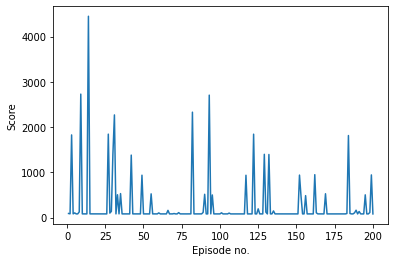

In [0]:
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
print(rs)
plt.plot([i+1 for i in range(0,200,1)], rs[:])
plt.xlabel('Episode no.')
plt.ylabel('Score')
plt.show()